# Introduction

This note book include my work on our project ---- Face mask detection.\
It detect face with Mtcnn and pred with ResNet\
Since general CNN performance not very well, we decided to choose some pre-trained model for better prediction.

# Dataset

https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

# Library

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import os
from PIL import Image
import cv2
import warnings
import os
import xmltodict
import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
from bs4 import BeautifulSoup
warnings.filterwarnings("ignore")

# Data Analysis

In [2]:
imgs_path="./Dataset/input/images/"  #local database path
anot_path="./Dataset/input/annotations/" 
img_file_name=[] #list of imagefile names
xml_file_name=[] #list of xmlfile names
types={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} # 3 types

In [3]:
for dirname, _, filenames in os.walk('./Dataset/input/'): # fill img_file_name & xml_file_name
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_file_name.append(filename)
        else:
            xml_file_name.append(filename)

## Dataset and its original label

In [4]:
def show_dataset(input_image): #function to visualize images
    with open(anot_path+input_image[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(imgs_path+input_image))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            if temp[i]["name"]=="with_mask":
                a,b,c,d=list(map(int,temp[i]["bndbox"].values()))
                patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='g',facecolor="none",)
                ax.add_patch(patch)
            if temp[i]["name"]=="without_mask":
                a,b,c,d=list(map(int,temp[i]["bndbox"].values()))     
                patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='r',facecolor="none",)
                ax.add_patch(patch)
            if temp[i]["name"]=="mask_weared_incorrect":
                a,b,c,d=list(map(int,temp[i]["bndbox"].values()))
                patch=patches.Rectangle((a,b),c-a,d-b,linewidth=1, edgecolor='y',facecolor="none",)
                ax.add_patch(patch)
    else:
        a,b,c,d=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"g","mask_weared_incorrect":"y"}
        patch=patches.Rectangle((a,b),d-b,c-a,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(patch)

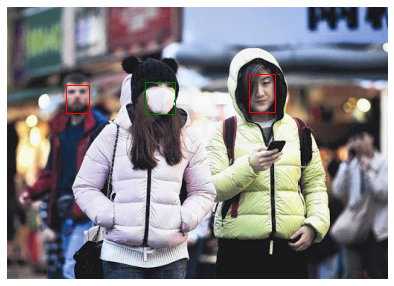

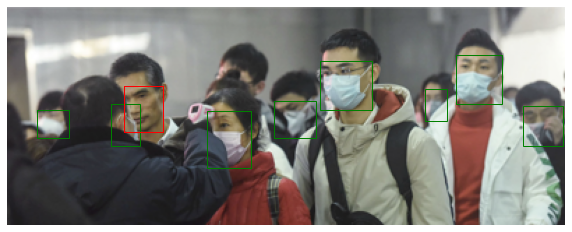

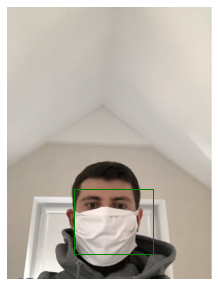

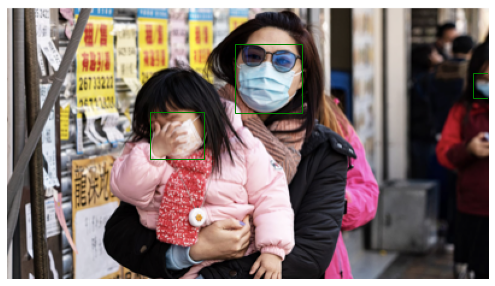

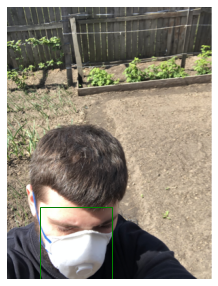

In [5]:
for i in range(0,5): # show some
    show_dataset(img_file_name[i])

## Crop the image into a subimage that contains only the face, then make it usable for training model


In [6]:
def make_dataset(no_of_images): #function to make dataset
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(no_of_images):
        with open(anot_path+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            a,b,c,d=list(map(int,temp["bndbox"].values())) # get the up,down,left and right of label
            label=types[temp["name"]]
            image=transforms.functional.crop(Image.open(imgs_path+j).convert("RGB"), b,a,d-b,c-a)# cut image
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                a,b,c,d=list(map(int,temp[k]["bndbox"].values()))
                label=types[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(imgs_path+j).convert("RGB"), b,a,d-b,c-a)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)

In [7]:
my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

dataset=make_dataset(img_file_name) #making a datset
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size
batch_size=32
trainset,testset=torch.utils.data.random_split(dataset,[train_size,test_size]) # devided to train set and test set
train_loader =DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
test_loader =DataLoader(dataset=testset,batch_size=batch_size,shuffle=True)

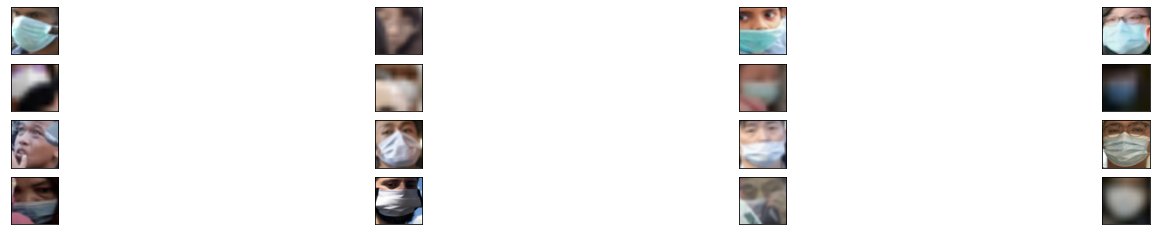

In [8]:
dataiter=iter(train_loader) 
images,labels=dataiter.next()
images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(16):      # show the cut image
    ax=fig.add_subplot(4,4,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(images[idx],(1,2,0)))

# Set model(ResNet)

In [9]:
resnet=models.resnet34(pretrained=True)

In [10]:
for param in resnet.parameters():
    param.requires_grad=False

In [11]:
n_inputs=resnet.fc.in_features
last_layer=nn.Linear(n_inputs,3)
resnet.fc.out_features=last_layer

if torch.cuda.is_available():
    resnet.cuda()
    
print(resnet.fc.out_features)

Linear(in_features=512, out_features=3, bias=True)


## Check environment

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'{torch.cuda.device_count()} GPU(s) available.')
    print(f'Using GPU:{torch.cuda.get_device_name(0)}')

1 GPU(s) available.
Using GPU:NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [13]:
for paramet in resnet.parameters():
    paramet.requires_grad=True

In [14]:
criterion=nn.CrossEntropyLoss()

optimizer=optim.SGD(resnet.parameters(),lr=0.001)

# Training

In [15]:
n_epochs=5

for epoch in range(1,n_epochs+1):
    train_loss = 0.0
    for batch,(data,target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data , target = data.cuda(), target.cuda()
    
        optimizer.zero_grad()
        output=resnet(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch%20==19:
            print(f'Epoch {epoch}, batch {batch+1}, training loss {train_loss/20}')
        train_loss = 0.0

Epoch 1, batch 20, training loss 0.1525470495223999
Epoch 1, batch 40, training loss 0.12896376848220825
Epoch 1, batch 60, training loss 0.06022865772247314
Epoch 1, batch 80, training loss 0.033646389842033386
Epoch 1, batch 100, training loss 0.02325557917356491
Epoch 2, batch 20, training loss 0.015162916481494903
Epoch 2, batch 40, training loss 0.04315902888774872
Epoch 2, batch 60, training loss 0.01395861804485321
Epoch 2, batch 80, training loss 0.0043514672666788105
Epoch 2, batch 100, training loss 0.02202146649360657
Epoch 3, batch 20, training loss 0.017803506553173067
Epoch 3, batch 40, training loss 0.02623169720172882
Epoch 3, batch 60, training loss 0.009509652853012085
Epoch 3, batch 80, training loss 0.003458678722381592
Epoch 3, batch 100, training loss 0.028182512521743773
Epoch 4, batch 20, training loss 0.0030473532155156136
Epoch 4, batch 40, training loss 0.008758288621902467
Epoch 4, batch 60, training loss 0.0018234437331557274
Epoch 4, batch 80, training los

# Testing

In [16]:
test_loss=0.0
acc=0
resnet.eval()

for data,target in test_loader:
    if torch.cuda.is_available():
        data,target=data.cuda(),target.cuda()
    output=resnet(data)
    loss=criterion(output,target)
    test_loss+=loss.item()
    _,pred=torch.max(output,1)
    predicted=pred.numpy()[:,np.newaxis] if not torch.cuda.is_available() else pred.cpu().numpy()[:,np.newaxis]
    actual=target.numpy()[:,np.newaxis] if not torch.cuda.is_available() else target.cpu().numpy()[:,np.newaxis]
    acc+=np.sum(predicted==actual)/len(target.cpu().numpy())

Average_loss=test_loss/len(test_loader)
Average_acc=acc/len(test_loader)

print("Avg total loss is {:.6f}".format(Average_loss))
print("Avg accuracy is {:.6f}".format(Average_acc))


Avg total loss is 0.328210
Avg accuracy is 0.931330


In [17]:
## save model
torch.save(resnet,open("resnet_model_face_mask","wb"))

### result of resnet

From this, clearly, resnet can predict well.

In [18]:
# a case of prediction
for data,target in test_loader:
    acc=0
    data,target=data.cuda(),target.cuda()
    output=resnet(data)
    _,pred=torch.max(output,1)
    predicted = pred.cpu().numpy()[:,np.newaxis]
    actual = target.cpu().numpy()[:,np.newaxis]
    acc+=np.sum(predicted==actual)/len(target.cpu().numpy())
    print(f'pred={predicted}, actual={actual}, acc={acc}')
    

pred=[[0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]], actual=[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]], acc=0.96875
pred=[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]], actual=[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]], acc=0.9375
pred=[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]], actual=[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 

pred=[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]], actual=[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [2]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]], acc=0.96875
pred=[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]], actual=[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]], acc=1.0


# load model

In [19]:
device = torch.device("cuda")
model=torch.load(open("./resnet_model_face_mask","rb"),map_location=device)
model=model.eval()

In [20]:
# !pip install mtcnn

In [21]:
# Face detection model
from mtcnn import MTCNN
detect=MTCNN()

In [22]:
def show_plot(bndbox,filepath,predicted):
    configut=["with_mask","without_mask","mask_weared_incorrect"]
    x=plt.imread(filepath)
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(15,10)
    for i,j in zip(bndbox,predicted):
        a,b,c,d=i["box"]
        patch=patches.Rectangle((a,b),c,d,linewidth=1, edgecolor='r',facecolor="none",)
        
        ax.text(a, b, configut[predicted[0]], size=10,
                style='italic',verticalalignment="bottom", horizontalalignment="left",color="blue")
        ax.add_patch(patch)
        ax.imshow(x)

In [23]:

def testing(filepath):
    configut=["with_mask","without_mask","mask_weared_incorrect"]
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    newimage=Image.open(filepath).convert("RGB")
    bndbox=detect.detect_faces(img)
    if len(bndbox)==1:
#         image_pred=trans(bndbox[0],newimage)
        a,b,c,d=bndbox[0]["box"]
        image_crop=transforms.functional.crop(newimage, b,a,d+b,c+a)
        image_pred=transforms.Compose([transforms.Resize((226,226)),
                                         transforms.RandomCrop((224,224)),
                                         transforms.ToTensor()])(image_crop).unsqueeze(0)
        _, pred=torch.max(model(image_pred.to(device)),1)
        show_plot(bndbox,filepath,predicted=pred)
    else:
        predicted=[]
        for i in bndbox:
#             image_pred=trans(i,newimage).unsqueeze(0)
            a,b,c,d=i["box"]
            image_crop=transforms.functional.crop(newimage, b,a,d+b,c+a)
            image_pred=transforms.Compose([transforms.Resize((226,226)),
                                             transforms.RandomCrop((224,224)),
                                             transforms.ToTensor()])(image_crop).unsqueeze(0)
            _, pred=torch.max(model(image_pred.to(device)),1)
            predicted.append(pred)
        show_plot(bndbox,filepath,predicted)

# Result

Problems
1. mtcnn didn't find all face in images
2. all labels are marked 'with_mask'

2/2 [==============================] - 0s 35ms/step


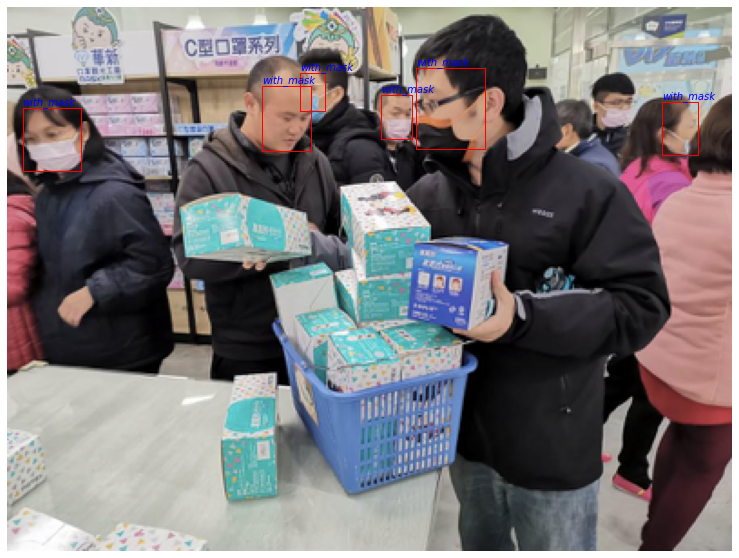

In [24]:
testing(imgs_path+img_file_name[131])

1/1 [==============================] - 0s 48ms/step


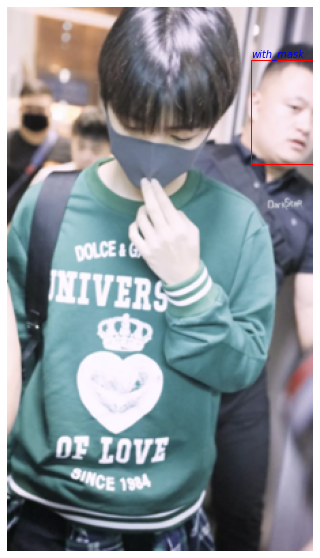

In [25]:
testing(imgs_path+img_file_name[188])

1/1 [==============================] - 0s 54ms/step


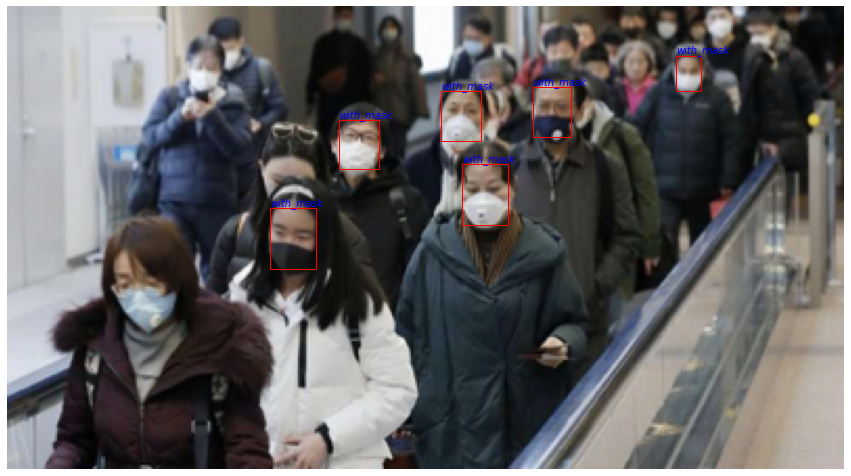

In [26]:
testing(imgs_path+img_file_name[220])

# Discussion

### analyze the result
>1. I need to train mtcnn with dataset for better performance 
>2. In testing part, the case show the ResNet can predict 3 classes correctlly, so the condition that all face   are predicted to 'with_mask'  is because of some coding mistake in mtcnn part.
### Work and Model performance
> At the very begining, I only use resnet to predict both face label and its classes. But there are two problem:
>> 1. it will predict multiple label for single person especially for those who wear mask incorrectlly ---- there will be three label represent all 3 classes in one person
>> 2. the progress of train model always takes lots of time, for some specific hyperparameter, it spends 1       hour, and i waste too much time on the model to correct the result but didn't work

> Then I try to divided the whole thing into two part: Face detection and mask detecion on the predicted face
>Advantages:
>> 1. Train resnet with only face part in images can be much faster then before, but I need another           model to detect humans' face and send it to resnet
>> 2. Now the accurecy is much more higher than before.

> Disadvantages:
>> 1. I use mtcnn directly without train, it obviously work not well. Lots of face did not detected. And the     process of train mtcnn still cost lots of time.
>> 2. I made some mistake on data transfer from mtcnn to resnet and i can't correct it before due. So although     resnet work very well, I still can not show its perfermence with image.

# Reference 

Reference: https://www.kaggle.com/code/punithanand/face-mask-detection-multi-class-labels/notebook